<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/Image_Classification_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install transformers
!pip install keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [59]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import accuracy_score


In [60]:
# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


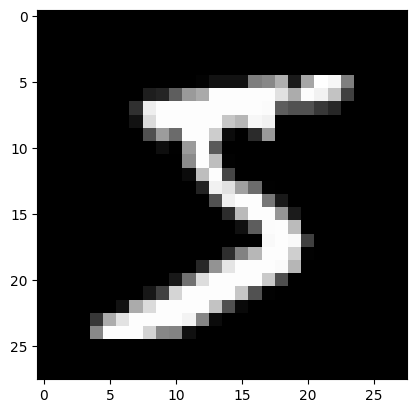

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap="gray", interpolation="nearest")

In [62]:
#print(X_train[0])

In [63]:
X_train.shape

(60000, 28, 28)

Vision Transformers expect 3D input (e.g., 224×224×3). MNIST images are 28×28 grayscale.

In [64]:
''' uses all RAM and crashes
X_train = tf.image.resize(tf.expand_dims(X_train, -1), [224, 224])
X_test = tf.image.resize(tf.expand_dims(X_test, -1), [224, 224])
X_train = tf.repeat(X_train, 3, axis=-1)  # Convert grayscale to 3-channel RGB
X_test = tf.repeat(X_test, 3, axis=-1)
'''

' uses all RAM and crashes\nX_train = tf.image.resize(tf.expand_dims(X_train, -1), [224, 224])\nX_test = tf.image.resize(tf.expand_dims(X_test, -1), [224, 224])\nX_train = tf.repeat(X_train, 3, axis=-1)  # Convert grayscale to 3-channel RGB\nX_test = tf.repeat(X_test, 3, axis=-1)\n'

In [65]:
import tensorflow as tf

def preprocess(image, label):
    image = tf.expand_dims(image, -1)  # Add channel dimension
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)  # Converts to 3 channels
    image = tf.cast(image, tf.float32) / 255.0

    # Random Rotation: Rotate image by a random angle in radians
    image = tf.image.rot90(image)  # Example of rotation. Adjust based on need.

    # Random Zoom: Random zoom using scale
    scale = tf.random.uniform([], 0.9, 1.1)
    image = tf.image.resize(image, [tf.cast(224*scale, tf.int32), tf.cast(224*scale, tf.int32)])
    image = tf.image.resize(image, [224, 224])  # Resize back to target size

    # Random Shift (Width and Height)
    image = tf.image.random_flip_left_right(image)  # Horizontal flip
    image = tf.image.random_flip_up_down(image)  # Vertical flip
    image = tf.image.random_crop(image, size=[224, 224, 3])  # Random crop to 224x224

    return image, tf.one_hot(label, 10)

batch_size = 64

# Create the full train dataset
full_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

# Calculate the validation size, for example, 20% of the dataset
val_size = int(0.2 * len(full_train_ds))

# Split the dataset: first take the validation set, then the training set
val_ds = full_train_ds.take(val_size)  # Take the first 20% as validation
train_ds = full_train_ds.skip(val_size)  # Skip the first 20% for training


In [66]:
from transformers import ViTFeatureExtractor, TFViTForImageClassification
from transformers import DefaultDataCollator

model = TFViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTForImageClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_mnist_model.h5", save_best_only=True)

In [68]:
len(train_ds)

751

In [69]:
# Train the model using the augmented train_ds in batches
history = model.fit(
    train_ds,  # The augmented training dataset with batching
    epochs=5,
    validation_data=val_ds,  # The validation dataset (no augmentation)
    callbacks=[early_stop, checkpoint]  # Early stopping and model checkpoint callbacks
)


Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1652, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_file1hntv1u_.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_filenylb3gcs.py", line 17, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).vit, (), dict(pixel_values=ag__.ld(pixel_values), head_mask=ag__.ld(head_mask), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_file1hntv1u_.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_file6r43o_gc.py", line 24, in tf__call
        embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(pixel_values=ag__.ld(pixel_values), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_filefbo2jemp.py", line 12, in tf__call
        embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_filecs3_5xhb.py", line 63, in tf__call
        projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)

    ValueError: Exception encountered when calling layer 'tf_vi_t_for_image_classification_4' (type TFViTForImageClassification).
    
    in user code:
    
        File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 862, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 871, in call  *
            outputs = self.vit(
        File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_file1hntv1u_.py", line 40, in tf__run_call_with_unpacked_inputs
            raise
        File "/tmp/__autograph_generated_file6r43o_gc.py", line 24, in tf__call
            embedding_output = ag__.converted_call(ag__.ld(self).embeddings, (), dict(pixel_values=ag__.ld(pixel_values), interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
        File "/tmp/__autograph_generated_filefbo2jemp.py", line 12, in tf__call
            embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
        File "/tmp/__autograph_generated_filecs3_5xhb.py", line 63, in tf__call
            projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'vit' (type TFViTMainLayer).
        
        in user code:
        
            File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 862, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 595, in call  *
                embedding_output = self.embeddings(
            File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/tmp/__autograph_generated_filefbo2jemp.py", line 12, in tf__call
                embeddings = ag__.converted_call(ag__.ld(self).patch_embeddings, (ag__.ld(pixel_values),), dict(interpolate_pos_encoding=ag__.ld(interpolate_pos_encoding), training=ag__.ld(training)), fscope)
            File "/tmp/__autograph_generated_filecs3_5xhb.py", line 63, in tf__call
                projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
        
            ValueError: Exception encountered when calling layer 'embeddings' (type TFViTEmbeddings).
            
            in user code:
            
                File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 129, in call  *
                    embeddings = self.patch_embeddings(
                File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
                File "/tmp/__autograph_generated_filecs3_5xhb.py", line 63, in tf__call
                    projection = ag__.converted_call(ag__.ld(self).projection, (ag__.ld(pixel_values),), None, fscope)
            
                ValueError: Exception encountered when calling layer 'patch_embeddings' (type TFViTPatchEmbeddings).
                
                in user code:
                
                    File "/usr/local/lib/python3.11/dist-packages/transformers/models/vit/modeling_tf_vit.py", line 204, in call  *
                        projection = self.projection(pixel_values)
                    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
                        raise e.with_traceback(filtered_tb) from None
                    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
                        raise ValueError(
                
                    ValueError: Input 0 of layer "projection" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 224, 3, 224)
                
                
                Call arguments received by layer 'patch_embeddings' (type TFViTPatchEmbeddings):
                  • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
                  • interpolate_pos_encoding=None
                  • training=True
            
            
            Call arguments received by layer 'embeddings' (type TFViTEmbeddings):
              • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
              • interpolate_pos_encoding=None
              • training=True
        
        
        Call arguments received by layer 'vit' (type TFViTMainLayer):
          • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
          • head_mask=None
          • output_attentions=False
          • output_hidden_states=False
          • interpolate_pos_encoding=None
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tf_vi_t_for_image_classification_4' (type TFViTForImageClassification):
      • pixel_values=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
      • head_mask=None
      • output_attentions=None
      • output_hidden_states=None
      • interpolate_pos_encoding=None
      • return_dict=None
      • labels=None
      • training=True


In [ ]:
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs_range, history.history['accuracy'], label="Training accuracy", color='blue')
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Training vs Validation accuracy")
plt.legend()
plt.show()